# Определение перспективного тарифа для телеком компании

В компании оператора сотовой связи клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Доступны данные 500 пользователей «Мегалайна» за 2018 год.

Задачи:
1. Предварительный анализ тарифов на небольшой выборке клиентов. 
2. Анализ поведения клиентов
3. Сделать вывод — какой тариф лучше.

## 1. Описание тарифов

**Тариф «Смарт»**

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* Минута разговора: 3 рубля
* Сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* Минута разговора: 1 рубль
* Сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

*Замечаие.* «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## 2. Описание данных

**Информация о пользователях**

* _user_id_ — уникальный идентификатор пользователя
* _first_name_ — имя пользователя
* _last_name_ — фамилия пользователя
* _age_ — возраст пользователя (годы)
* _reg_date_ — дата подключения тарифа (день, месяц, год)
* _churn_date_ — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* _city_ — город проживания пользователя
* _tariff_ — название тарифного плана

**Информация о звонках**

* _id_ — уникальный номер звонка
* _call_date_ — дата звонка
* _duration_ — длительность звонка в минутах
* _user_id_ — идентификатор пользователя, сделавшего звонок

**Информация о сообщениях**

* _id_ — уникальный номер сообщения
* _message_date_ — дата сообщения
* _user_id_ — идентификатор пользователя, отправившего сообщение

**Информация об интернет-сессиях**

* _id_ — уникальный номер сессии
* _mb_used_ — объём потраченного за сессию интернет-трафика (в мегабайтах)
* _session_date_ — дата интернет-сессии
* _user_id_ — идентификатор пользователя

**Информация о тарифах**

* _tariff_name_ — название тарифа
* _rub_monthly_fee_ — ежемесячная абонентская плата в рублях
* _minutes_included_ — количество минут разговора в месяц, включённых в абонентскую плату
* _messages_included_ — количество сообщений в месяц, включённых в абонентскую плату
* _mb_per_month_included_ — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* _rub_per_minute_ — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* _rub_per_message_ — стоимость отправки сообщения сверх тарифного пакета
* _rub_per_gb_ — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## 3. Функции

In [1]:
import math
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from urllib.parse import urlencode

In [2]:
LINKS = ["https://yadi.sk/d/-yfOw4HHtN0vAw", "https://yadi.sk/d/FOhKnSHxJXPayg", 
         "https://yadi.sk/d/W4Q2ViomDMAjYA", "https://yadi.sk/d/ZANkXDZcnRG_bw", 
         "https://yadi.sk/d/pEYK_9PZgE2C_Q"]
PATHS = ['a/datasets/calls.csv', 'a/datasets/internet.csv', 'a/datasets/messages.csv', 
         'a/datasets/tariffs.csv', 'a/datasets/users.csv']

In [3]:
def load_data(paths, links=None):
    """
    Функция принимает пути до локальных файлов с данными и (опционально) ссылки
    для их скачивания.
    
    paths - локальные пути до файлов с данными
    links - ссылки для скачивания (Яндекс.Диск)
    """
    
    data_list = []
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    if links != None and not links:
        raise Exception("Error: wrong 'links' value (nmust be not empty list)")
    
    if links:
        if len(paths) != len(links):
            raise Exception("Error: length of 'links' must be equal to length of 'paths'")

        if type(paths).__name__ != 'list' or type(links).__name__ != 'list':
            raise Exception("Error: variables 'links' and 'paths' must be 'list' type")

    for i in range(len(paths)):
        
        try:
            path = paths[i]
            data_list.append(pd.read_csv(path))
            
        except FileNotFoundError:
            # download from yandex disk
            public_key = links[i]
            print("Run load", public_key)
            
            # get download link
            final_url = base_url + urlencode(dict(public_key=public_key))
            response = requests.get(final_url)
            download_url = response.json()['href']
            data = pd.read_csv(download_url)
            data_list.append(pd.DataFrame(data))
            print('Done.')
            
    return data_list

In [4]:
# ---------- UPDATE -----------
# функция доп. вычислений
def diff_values(row, per_month, included, rub,  proc=False):
    # diff = math.ceil(row[per_month] - row[included])
    diff = row[per_month] - row[included]
    
    if proc:
        # update 2.0 :D
        diff /= 1024
        
    # update 2.0
    fee = int(math.ceil(diff)) * row[rub] if diff > 0 else 0
    return fee

In [5]:
# ---------- UPDATE -----------
# функция для подстчета прибыли из каждой строки
def calculate_income(row):
    minutes = diff_values(row, 'minutes_per_month', 'minutes_included', 'rub_per_minute')
    messages = diff_values(row, 'message_per_month', 'messages_included', 'rub_per_message')
    gb = diff_values(row, 'mb_per_month', 'mb_per_month_included', 'rub_per_gb', proc=True) 
    # update 2.0
    result = minutes + messages + gb + row['rub_monthly_fee']
    return result

In [6]:
# функция построения нескольких графиков

def get_figure(df_list, labels, kind, title, ax, legend=False): 
    for i, df in enumerate(df_list):
        df.plot(ax=ax, label=labels[i], kind=kind, title=title, grid=True);

In [7]:
# функция построения диаграмы размаха для параметров 'minutes_per_month', 'message_per_month', 'mb_per_month'

def get_boxplot(df, tariff):
    fig, axs = plt.subplots(1, 3, figsize=(15,10))

    for i, point in enumerate(['minutes_per_month', 'message_per_month', 'mb_per_month']):
        get_figure([df[[point]]], [tariff], 'box', point, axs[i])

    fig.tight_layout();

In [8]:
# функция для получения границ дтапазона [-1.5*iqr, +1.5*iqr]

def get_true_range(s):
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - 1.5 * iqr, 2)
    third = round(quantile[0.75] + 1.5 * iqr, 2)
    return (first, third)   

In [9]:
# функция удаления выбросов
def drop_values(df):
    minutes_range = get_true_range(df['minutes_per_month'])
    messages_range = get_true_range(df['message_per_month'])
    mb_range = get_true_range(df['mb_per_month'])
    
    df.drop(df[(df['minutes_per_month'] < minutes_range[0])
               | (df['minutes_per_month'] > minutes_range[1])
               | (df['message_per_month'] < messages_range[0])
               | (df['message_per_month'] > messages_range[1])
               | (df['mb_per_month'] < mb_range[0])
               | (df['mb_per_month'] > mb_range[1])].index,
                axis=0,
                inplace=True
               )
    
    return df

In [10]:
# функция удаления выбросов
def drop_values(df):
    minutes_range = get_true_range(df['minutes_per_month'])
    messages_range = get_true_range(df['message_per_month'])
    mb_range = get_true_range(df['mb_per_month'])
    
    df.drop(df[(df['minutes_per_month'] < minutes_range[0])
               | (df['minutes_per_month'] > minutes_range[1])
               | (df['message_per_month'] < messages_range[0])
               | (df['message_per_month'] > messages_range[1])
               | (df['mb_per_month'] < mb_range[0])
               | (df['mb_per_month'] > mb_range[1])].index,
                axis=0,
                inplace=True
               )
    
    return df

In [11]:
# функция проверки нулевой гипотезы

def check_null_hypothesis(sample_1, sample_2):
    alpha = 0.05
    results = st.ttest_ind(sample_1, sample_2, equal_var=True)
    print('p-value:', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не удалось отвергнуть нулевую гипотезу')

## 4. Загрузка данных

In [12]:
calls_data, internet_data, messages_data, tariffs_data, users_data = load_data(PATHS, links=LINKS)

Run load https://yadi.sk/d/-yfOw4HHtN0vAw
Done.
Run load https://yadi.sk/d/FOhKnSHxJXPayg
Done.
Run load https://yadi.sk/d/W4Q2ViomDMAjYA
Done.
Run load https://yadi.sk/d/ZANkXDZcnRG_bw
Done.
Run load https://yadi.sk/d/pEYK_9PZgE2C_Q
Done.


In [13]:
# calls_data = pd.read_csv('/datasets/calls.csv')
calls_data.sample(10)

,id,call_date,duration,user_id
190398,1469_17,2018-08-31,7.17,1469
38255,1096_19,2018-09-30,2.70,1096
61204,1155_12,2018-04-22,0.00,1155
94725,1240_253,2018-11-17,7.54,1240
69628,1174_668,2018-07-26,0.49,1174
180051,1450_69,2018-12-28,0.00,1450
70062,1175_211,2018-05-20,0.00,1175
176432,1435_350,2018-06-24,0.38,1435
21009,1055_502,2018-05-09,8.39,1055
18726,1051_115,2018-10-04,3.51,1051


In [14]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [15]:
calls_data[calls_data.duration == 0.0].shape

(39613, 4)

In [16]:
# internet_data = pd.read_csv('/datasets/internet.csv')
internet_data.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
24015,24015,1082_2,488.53,2018-10-15,1082
77677,77677,1262_329,0.00,2018-06-13,1262
76408,76408,1256_113,288.48,2018-11-24,1256
145722,145722,1487_65,732.64,2018-12-27,1487
33871,33871,1119_25,224.38,2018-07-09,1119
65628,65628,1224_274,741.58,2018-12-28,1224
122808,122808,1413_213,274.78,2018-12-30,1413
97468,97468,1328_25,500.48,2018-12-27,1328
113742,113742,1384_452,282.36,2018-05-18,1384
109593,109593,1373_515,306.01,2018-10-08,1373


In [17]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [18]:
# messages_data = pd.read_csv('/datasets/messages.csv')
messages_data.sample(10)

,id,message_date,user_id
110365,1447_50,2018-11-09,1447
66459,1284_47,2018-08-21,1284
104104,1423_437,2018-06-27,1423
63110,1275_72,2018-11-28,1275
66690,1284_278,2018-07-11,1284
98126,1401_458,2018-03-13,1401
9587,1039_243,2018-11-23,1039
29951,1130_326,2018-12-30,1130
69811,1299_91,2018-12-06,1299
14924,1065_260,2018-05-28,1065


In [19]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [20]:
# tariffs_data = pd.read_csv('/datasets/tariffs.csv')
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
tariffs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [22]:
# users_data = pd.read_csv('/datasets/users.csv')
users_data.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
221,1221,40,NaN,Белгород,Джемма,Сафонова,2018-06-03,smart
187,1187,60,NaN,Рязань,Виталий,Овчинников,2018-08-22,smart
258,1258,52,NaN,Санкт-Петербург,Валерий,Беляев,2018-12-31,smart
47,1047,67,NaN,Саратов,Милица,Меркулова,2018-10-29,smart
359,1359,52,NaN,Москва,Константин,Абашкин,2018-07-27,smart
444,1444,35,NaN,Нижний Новгород,Иулиан,Воронин,2018-11-07,smart
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
440,1440,51,NaN,Москва,Арсений,Матвеев,2018-05-28,ultra
77,1077,18,NaN,Москва,Марица,Кольцова,2018-10-23,smart
368,1368,50,NaN,Омск,Розалия,Гришина,2018-12-14,smart


In [23]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Вывод

Только в одной таблице обнаружены пропуски - таблица _users_data_, столбец _churn_date_ (дата окончания действия тарифа). В поставленной задаче данные этого столбца учитываться не будут, поэтому обработка пропусков не требуется.

В таблице calls_data множество звонков (39613) с длительностью 0.0 минут. Предположительно, это пропущенные звонки.

Неверно интерпретируется тип столбцов с датой  - потребуется приведение типов (формат _таблица-столбец_ ):
* _users_data_ - _churn_date, reg_date_
* _messages_data_ - _message_date_
* _calls_data_ - _call_date_
* _internet_data_ - _session_date_

В таблице _internet_data_ присутствует столбец без названия _"Unnamed: 0"_.

## 5. Подготовка данных

### 5.1. Преобразование типов данных

В каждой таблице тип данных столбцов с датами - строки. Преобразуем тип в _datetime_.

In [24]:
# В цикле осуществляем преобразование типов столбцов с датами

# users_data - churn_date, reg_date
# messages_data - message_date
# calls_data - call_date
# internet_data - session_date

columns = ['churn_date', 'reg_date', 'message_date', 'call_date', 'session_date']
tables =  [users_data, users_data, messages_data, calls_data, internet_data]
table_names =  ['users_data', 'users_data', 'messages_data', 'calls_data', 'internet_data']

for name, table, column in zip(table_names, tables, columns):
    table[column] = pd.to_datetime(table[column], format="%Y-%m-%d")
    # проверка
    print(table[[column]].dtypes[0])

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### 5.2. Исправление ошибок

В таблице _internet_data_ присутствует столбец без названия _"Unnamed: 0"_ , который совпадает с индексом. Предположительно, при сохранении в данных в текстовом формате, индекс был сохранен как столбец. Удалим столбец _"Unnamed: 0"_, так как он не понадобится при анализе.

In [25]:
internet_data.drop(['Unnamed: 0'], axis=1, inplace=True)

# проверка
internet_data.sample(5)

,id,mb_used,session_date,user_id
109546,1373_468,400.27,2018-05-13,1373
31824,1110_418,701.78,2018-12-26,1110
47197,1161_217,54.78,2018-09-19,1161
141933,1476_135,786.95,2018-12-30,1476
13180,1045_356,394.74,2018-04-18,1045


В таблицах _users_data, calls_data, messages_data, internet_data_ строковые данные столбцов _city, first_name, last_name, id, tariff_ приведем к одному регистру (нижнему).

In [26]:
str_columns = [
    ('users_data', users_data, 'city'),
    ('users_data', users_data, 'first_name'),
    ('users_data', users_data, 'last_name'),
    ('users_data', users_data, 'tariff'),
    ('calls_data', calls_data, 'id'),
    ('messages_data', messages_data, 'id'),
    ('internet_data', internet_data, 'id')
]

for name, table, column in str_columns:
    table[column] = table[column].str.lower()
    
    # проверка
    print('\nTable {}, column {}:'.format(name, column))
    print(table[[column]].sample(3))


Table users_data, column city:
        city
55    казань
346  саратов
219    киров

Table users_data, column first_name:
    first_name
464   антонина
277    валерия
434     карина

Table users_data, column last_name:
    last_name
12   соловьев
353  анищенко
414  лобанова

Table users_data, column tariff:
    tariff
464  smart
481  smart
305  smart

Table calls_data, column id:
              id
166177  1409_802
117386   1302_26
32123   1079_494

Table messages_data, column id:
              id
28212    1122_35
88195   1369_120
115142  1471_370

Table internet_data, column id:
              id
107859   1367_34
60115   1204_200
51285   1174_493


### 5.3. Дубликаты

In [27]:
items = [
    ('users_data', users_data),
    ('calls_data', calls_data),
    ('messages_data', messages_data),
    ('internet_data', internet_data),
    ('tariffs_data', tariffs_data)
]

for name, df in items:
    print("\nДубликаты в таблице {}:".format(name))
    print(df.duplicated().value_counts())


Дубликаты в таблице users_data:
False    500
dtype: int64

Дубликаты в таблице calls_data:
False    202607
dtype: int64

Дубликаты в таблице messages_data:
False    123036
dtype: int64

Дубликаты в таблице internet_data:
False    149396
dtype: int64

Дубликаты в таблице tariffs_data:
False    2
dtype: int64


Дублирование данных в таблицах отсутствует.

In [28]:
# посмотрим количество самых минимальных значений
calls_data['duration'].value_counts().sort_index().head(5)

0.00    39613
0.01      101
0.02       84
0.03       80
0.04       85
Name: duration, dtype: int64

In [29]:
# посмотрим количество самых минимальных значений для трафика
internet_data['mb_used'].value_counts().sort_index().head(5)

0.00    19598
0.03        1
0.04        1
0.06        1
0.07        2
Name: mb_used, dtype: int64

В данных присуствуют нулевые значения, а также значения до 1 минуты и до 1 мегабайта. Учитывая специфику работы ПО мобильных операторов:

_подсчет минут осуществляется по принципу N+1_

а также замечание при постановке задачи:

_«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута._

а также замечания ревьюера, выполним округление значений N+1 в бОльшую сторону для длительности вызовов и использованного траффика.

In [30]:
# ----- UPDATE ------
calls_data['duration'] = calls_data['duration'].apply(lambda x: math.ceil(x + 1))
internet_data['mb_used'] = internet_data['mb_used'].apply(lambda x: math.ceil(x + 1))

# проверка
print(calls_data['duration'].value_counts().sort_index().head(5))
print(internet_data['mb_used'].value_counts().sort_index().head(5))

1    39613
2     8402
3     9194
4    10362
5    10918
Name: duration, dtype: int64
1    19598
2      102
3       98
4       96
5      100
Name: mb_used, dtype: int64


### 5.4. Насыщение данных

Для удобства рассчетов для каждой даты каждой таблицы добавим отдельную колонку с месяцем.

In [31]:
tables = [users_data, calls_data, messages_data, internet_data, tariffs_data]

for tab in tables:
    for col in tab.columns.to_list():
        if 'date' in col:
            tab['month'] = tab[col].dt.month
            
            # для пропущенных значений заполним 0 и переведем в тип int
            if tab['month'].isna().count():
                tab['month'].fillna(0, inplace=True)
                tab['month'] = tab['month'].astype('int')
                
            # проверка
            print("{}\t{}".format('month', tab['month'].dtypes))

month	int64
month	int64
month	int64
month	int64
month	int64


**Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя**

In [32]:
calls_data['minutes_per_month'] = calls_data.groupby(['user_id','month'])['duration'].transform('sum')
calls_data.sort_values(by=['user_id','call_date']).sample(10)

,id,call_date,duration,user_id,month,minutes_per_month
122715,1317_224,2018-07-10,8,1317,7,518
64022,1164_175,2018-10-17,21,1164,10,399
41314,1101_357,2018-06-04,1,1101,6,619
55513,1142_157,2018-07-22,1,1142,7,586
13891,1036_65,2018-10-27,12,1036,10,602
51994,1130_282,2018-12-20,2,1130,12,670
34672,1086_221,2018-06-11,10,1086,6,529
102087,1262_444,2018-06-08,11,1262,6,375
114114,1291_740,2018-11-09,10,1291,11,641
41120,1101_163,2018-11-26,11,1101,11,703


**Количество отправленных сообщений по месяцам для каждого пользователя**

In [33]:
messages_data['message_per_month'] = messages_data.groupby(['user_id', 'month'])['id'].transform('count')
messages_data.sort_values(by=['user_id','message_date']).sample(10)

,id,message_date,user_id,month,message_per_month
119252,1483_187,2018-04-11,1483,4,30
13779,1057_121,2018-08-14,1057,8,19
69350,1296_92,2018-12-13,1296,12,50
89209,1373_221,2018-08-25,1373,8,56
106994,1431_736,2018-08-28,1431,8,91
72729,1308_189,2018-03-05,1308,3,23
32468,1145_121,2018-05-10,1145,5,103
81995,1344_59,2018-08-29,1344,8,132
80078,1333_434,2018-12-23,1333,12,145
88199,1369_124,2018-12-19,1369,12,115


**Объем израсходованного интернет-трафика по месяцам для каждого пользователя**

In [34]:
internet_data['mb_per_month'] = internet_data.groupby(['user_id', 'month'])['mb_used'].transform('sum')
internet_data.sort_values(by=['user_id', 'session_date']).sample(10)

,id,mb_used,session_date,user_id,month,mb_per_month
85086,1290_116,919,2018-12-06,1290,12,29828
105582,1357_9,183,2018-12-28,1357,12,18026
60628,1204_713,216,2018-05-29,1204,5,17530
54258,1181_70,18,2018-12-30,1181,12,28337
19756,1066_237,571,2018-08-15,1066,8,31091
73460,1248_29,391,2018-10-08,1248,10,21094
148338,1496_286,757,2018-07-18,1496,7,24463
73271,1247_309,410,2018-09-07,1247,9,20440
86055,1292_171,364,2018-11-30,1292,11,29646
16349,1056_153,225,2018-07-01,1056,7,14424


**Помесячная выручка с каждого пользователя**

In [35]:
# подготавливаем необходимые данные, чтобы соединить в одну таблицу

# выделение нужных столбцов
data_list = [
    calls_data[['user_id','month','minutes_per_month']],
    messages_data[['user_id', 'month', 'message_per_month']],
    internet_data[['user_id', 'month', 'mb_per_month']]
]

# будем использовать join(), поэтому для корректного объединения будем 
# использовать мульти-индекс 'пользователь-месяц'
data_for_join = [ df.drop_duplicates().set_index(['user_id','month']) for df in data_list ]

In [36]:
# создаем новую таблицу
general_data = data_for_join[0].join(data_for_join[1:]).reset_index()
general_data.sample(5)

,user_id,month,minutes_per_month,message_per_month,mb_per_month
97,1012,3,18.0,2.0,2422.0
1685,1270,9,327.0,46.0,11038.0
3082,1482,5,419.0,61.0,12501.0
1496,1240,8,511.0,NaN,48488.0
1816,1291,7,621.0,NaN,16688.0


In [37]:
# изменим имя столбца для возможности дальнейшего объединения
tariffs_data.rename(columns={'tariff_name':'tariff'}, inplace=True)

In [38]:
# сразу объединяем с данными о пользователе и тарифном плане
# здесь меньше данных, удобнее использовать merge()
general_data = (
    general_data
    .merge(users_data[['user_id','tariff','city']],on='user_id')
    .merge(tariffs_data, on='tariff')
)

In [39]:
general_data.sample(5)

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1963,1217,4,522.0,62.0,17235.0,smart,ульяновск,50,15360,500,550,200,3,3
1080,1027,6,505.0,14.0,14749.0,smart,петрозаводск,50,15360,500,550,200,3,3
1487,1118,6,770.0,NaN,14244.0,smart,казань,50,15360,500,550,200,3,3
427,1257,9,1.0,153.0,22820.0,ultra,санкт-петербург,1000,30720,3000,1950,150,1,1
834,1436,9,465.0,24.0,22632.0,ultra,москва,1000,30720,3000,1950,150,1,1


In [40]:
# проверка - нет ли пропущенных значений
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3174 non-null   int64  
 1   month                  3174 non-null   int64  
 2   minutes_per_month      3174 non-null   float64
 3   message_per_month      2678 non-null   float64
 4   mb_per_month           3163 non-null   float64
 5   tariff                 3174 non-null   object 
 6   city                   3174 non-null   object 
 7   messages_included      3174 non-null   int64  
 8   mb_per_month_included  3174 non-null   int64  
 9   minutes_included       3174 non-null   int64  
 10  rub_monthly_fee        3174 non-null   int64  
 11  rub_per_gb             3174 non-null   int64  
 12  rub_per_message        3174 non-null   int64  
 13  rub_per_minute         3174 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 372.0+ 

Полученная таблица показывает, что одна часть пользователей не пользовалась мобильным интернетом в течение некоторых месяцев, другая - не отправляла сообщения. Заполним пропуски 0.

In [41]:
general_data[['message_per_month', 'mb_per_month']] = general_data[['message_per_month', 'mb_per_month']].fillna(0)
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3174 non-null   int64  
 1   month                  3174 non-null   int64  
 2   minutes_per_month      3174 non-null   float64
 3   message_per_month      3174 non-null   float64
 4   mb_per_month           3174 non-null   float64
 5   tariff                 3174 non-null   object 
 6   city                   3174 non-null   object 
 7   messages_included      3174 non-null   int64  
 8   mb_per_month_included  3174 non-null   int64  
 9   minutes_included       3174 non-null   int64  
 10  rub_monthly_fee        3174 non-null   int64  
 11  rub_per_gb             3174 non-null   int64  
 12  rub_per_message        3174 non-null   int64  
 13  rub_per_minute         3174 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 372.0+ 

In [42]:
# # функция для подстчета прибыли из каждой строки
# def calculate_income(row):
#     minutes = 0
#     messages = 0
#     gb = 0
    
#     # TODO - to reduce it!
#     diff = math.ceil(row['minutes_per_month'] - row['minutes_included'])
#     minutes = diff * row['rub_per_minute'] if diff > 0 else 0
    
#     diff = math.ceil(row['message_per_month'] - row['messages_included'])
#     messages = diff * row['rub_per_message'] if diff > 0 else 0
    
#     diff = math.ceil(math.ceil(row['mb_per_month'] - row['mb_per_month_included']))/1000
#     gb = diff * row['rub_per_gb'] if diff > 0 else 0
    
#     result = round(float(minutes + messages + gb + row['rub_monthly_fee']), 1)
#     return result

In [43]:
general_data['income'] = general_data.apply(calculate_income, axis=1)
general_data.sample(5)

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
2988,1460,7,695.0,42.0,11493.0,smart,ижевск,50,15360,500,550,200,3,3,1135
778,1402,7,639.0,27.0,25791.0,ultra,пенза,1000,30720,3000,1950,150,1,1,1950
1660,1155,11,623.0,47.0,16062.0,smart,ставрополь,50,15360,500,550,200,3,3,1119
164,1096,9,417.0,79.0,12285.0,ultra,брянск,1000,30720,3000,1950,150,1,1,1950
2264,1286,11,56.0,12.0,4853.0,smart,москва,50,15360,500,550,200,3,3,550


Из  таблицы _general_data_ выделим 2 отдельные таблицы с разными тарифами.

In [44]:
# отдельно сохраним данные по тарифу ultra
ultra_data = general_data[general_data.tariff == 'ultra']
ultra_data.head()

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,7,387.0,75.0,14045.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
1,1000,8,460.0,81.0,14099.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
2,1000,6,215.0,60.0,23306.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
3,1000,9,524.0,57.0,14608.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
4,1000,12,379.0,70.0,9848.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950


In [45]:
# отдельно сохраним данные по тарифу smart
smart_data = general_data[general_data.tariff == 'smart']
smart_data.head()

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
951,1001,11,489.0,0.0,18507.0,smart,москва,50,15360,500,550,200,3,3,1350
952,1001,12,477.0,0.0,14094.0,smart,москва,50,15360,500,550,200,3,3,550
953,1002,9,242.0,4.0,16768.0,smart,стерлитамак,50,15360,500,550,200,3,3,950
954,1002,8,331.0,13.0,20407.0,smart,стерлитамак,50,15360,500,550,200,3,3,1550
955,1002,12,269.0,12.0,18199.0,smart,стерлитамак,50,15360,500,550,200,3,3,1150


### 5.5. Выбросы

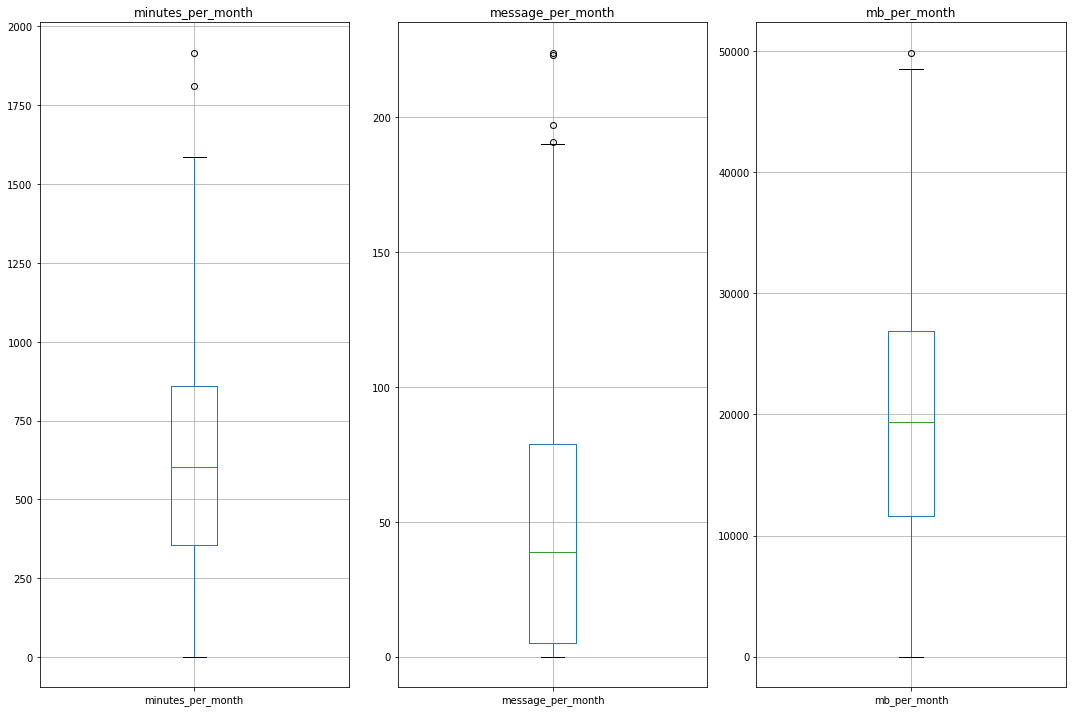

In [46]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в месяц для тарифа ultra
get_boxplot(ultra_data, 'ultra')

В данных количества израсходованных минут, сообщений и трафика присутствуют выбросы. Посмотрим на их количество.

In [47]:
before_ultra = ultra_data.shape

In [48]:
get_true_range(ultra_data.minutes_per_month)[1]

1618.25

Удалим выбросы из данных.

In [49]:
# удаление выбросов
ultra_data = drop_values(ultra_data)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
# # верхнюю границу доверительного интервала для разных показателей
# minutes_range = get_true_range(ultra_data.minutes_per_month)[1]
# messages_range = get_true_range(ultra_data.message_per_month)[1]
# mb_range = get_true_range(ultra_data.mb_per_month)[1]

# ultra_data.drop(ultra_data[(ultra_data.minutes_per_month > minutes_range)
#                            | (ultra_data.message_per_month > messages_range)
#                            | (ultra_data.mb_per_month > mb_range)].index,
#                 axis=0,
#                 inplace=True
#                )

In [51]:
# посмотрим, сколько данных выбросили
print(before_ultra)
print(ultra_data.shape)

(951, 15)
(944, 15)


Потряли 22 записи. От общего количества - 2.3%.

**UPD:** Удалили 7 записей

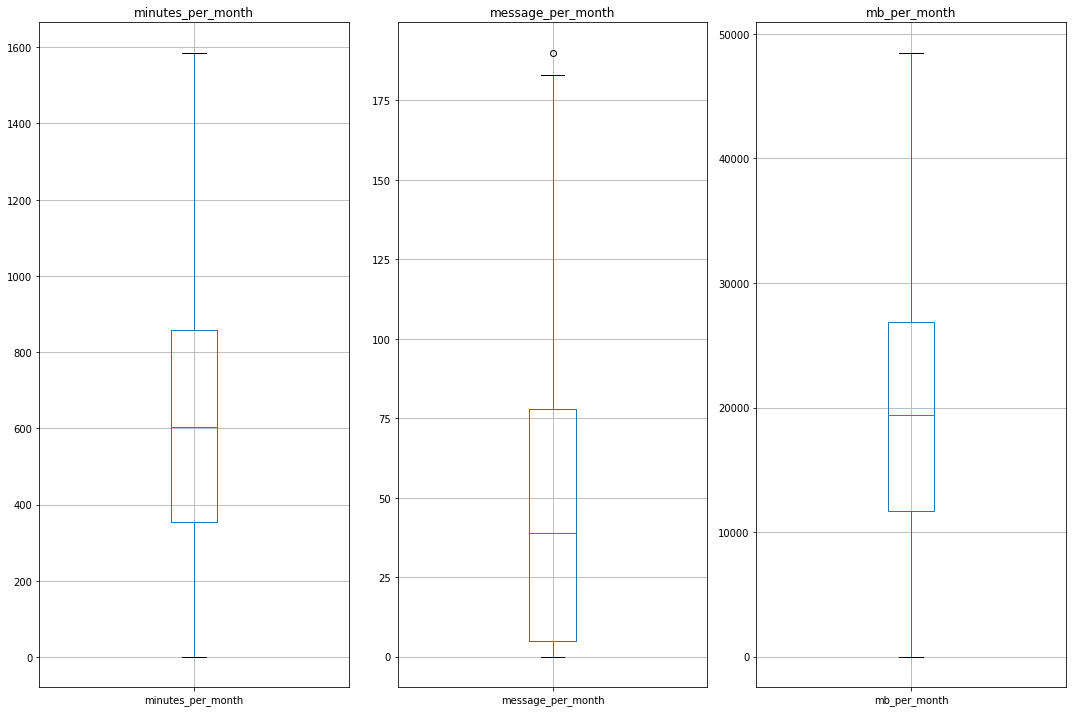

In [52]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в месяц для тарифа ultra
# после удаления выбросов
get_boxplot(ultra_data, 'ultra')

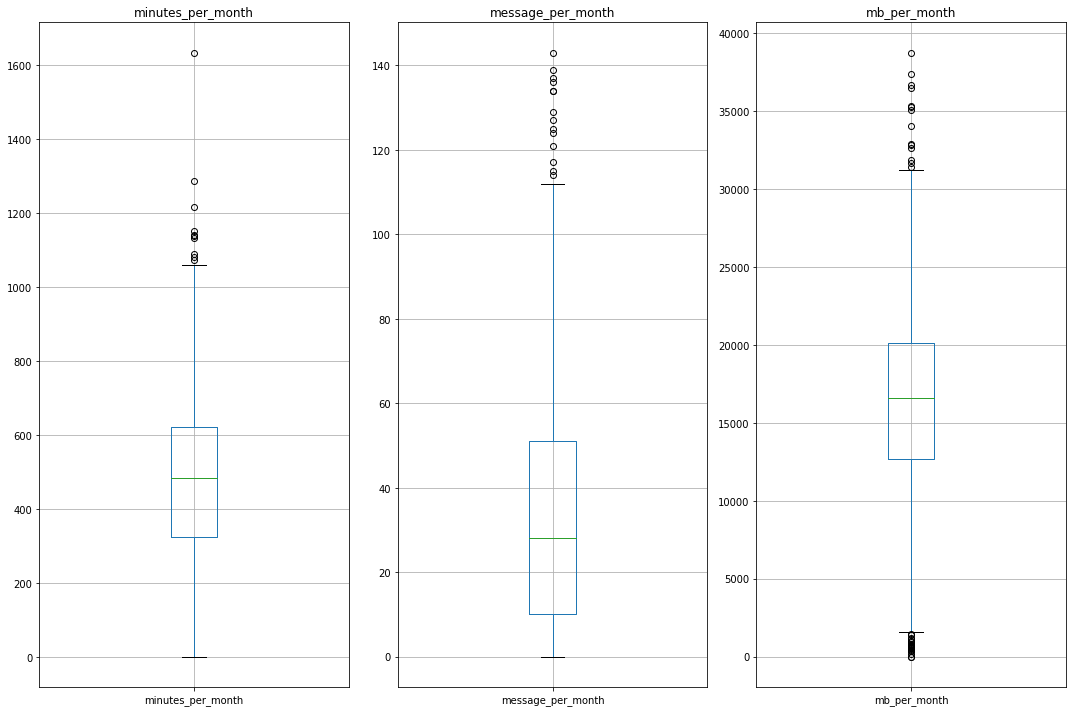

In [53]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в месяц для тарифа smart
get_boxplot(smart_data, 'smart')

Для тарифа _smart_ намного больше выбросов.

In [54]:
# размер данных до обработки выбросов
before_smart = smart_data.shape

In [55]:
# удаление выбросов
smart_data = drop_values(smart_data)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [56]:
# # получаем доверительный интервал для минут
# min_range = get_true_range(smart_data.minutes_per_month)

# # размер данных внутри доверительного интервала
# smart_data[(smart_data.minutes_per_month >= min_range[0]) & (smart_data.minutes_per_month <= min_range[1])].shape

In [57]:
# # получаем доверительный интервал для сообщений
# mes_range = get_true_range(smart_data.message_per_month)

# # размер данных внутри доверительного интервала
# smart_data[(smart_data.message_per_month >= mes_range[0]) & (smart_data.message_per_month <= mes_range[1])].shape

In [58]:
# # получаем доверительный интервал для трафика
# mb_range = get_true_range(smart_data.mb_per_month)

# # размер данных внутри доверительного интервала
# smart_data[(smart_data.mb_per_month >= mb_range[0]) & (smart_data.mb_per_month <= mb_range[1])].shape

In [59]:
# # for r, c in [(min_range, 'minutes_per_month'), (mes_range,'message_per_month'), (mb_range,'mb_per_month')];
# # удалим выбросы

# smart_data.drop(smart_data[(smart_data.minutes_per_month < min_range[0])
#                            | (smart_data.minutes_per_month > min_range[1])
#                            | (smart_data.message_per_month < mes_range[0])
#                            | (smart_data.message_per_month > mes_range[1])
#                            | (smart_data.mb_per_month < mb_range[0])
#                            | (smart_data.mb_per_month > mb_range[1])].index,
#                 axis=0,
#                 inplace=True
#                )

In [60]:
print(before_smart)
print(smart_data.shape)

(2223, 15)
(2164, 15)


Удалены 59 записей - 2.7%.

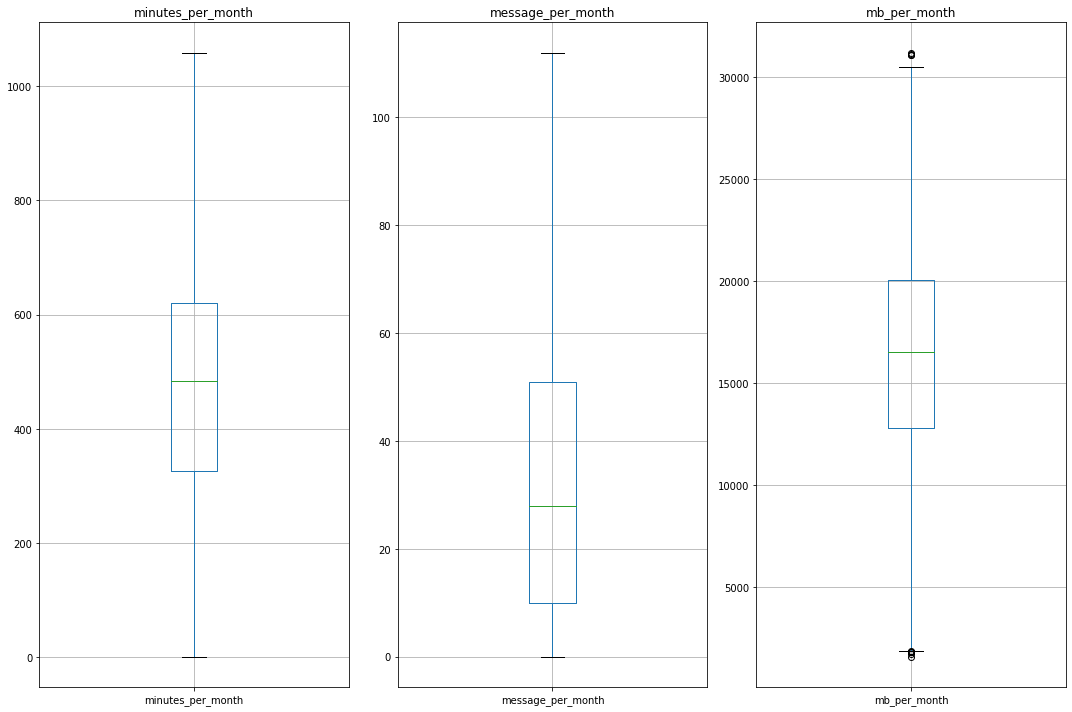

In [61]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в месяц для тарифа smart
# после удаления выбросов
get_boxplot(smart_data, 'smart')

### Вывод

* Изменены типы данных
* Удалены лишние столбцы
* Проведен поиск пропусков - обнаруженные пропуски нет смсла заменять
* Проведен поиск дубликатов - отсутствуют
* Строковые данные приведены к согласованному виду
* Выполнено добавление данных по месяцам для каждого пользователя:
    * расход минут
    * расход сообщений
    * расход трафика
    * общий доход
* Данные разделены на 2 отдельные талицы для каждого тарифа
* Для каждого тарифа удалены выбросы для количества израсходованных минут, сообщений и трафика.

## 5. Анализ

In [62]:
# # посторим графики для каждого тарифа по месяцам для демонстрации расхода минут, сообщений и трафика
# fig, axs = plt.subplots(1, 3, figsize=(15,6))

# for ax, point in zip(axs, ['minutes_per_month', 'message_per_month', 'mb_per_month']):
#     udata = ultra_data.groupby('month')[[point]].sum()
#     sdata = smart_data.groupby('month')[[point]].sum()
    
#     for df, lb in zip([udata, sdata], ['ultra', 'smart']):
#         ax.plot(df, label=lb)
#         ax.set_ylabel(point)
#         ax.set_xlabel('month')
#         ax.legend(loc="upper left")
        
# fig.tight_layout()

Для оценки расхода минут, сообщений и траффика посмотрим на график _среднего_ по месяцам

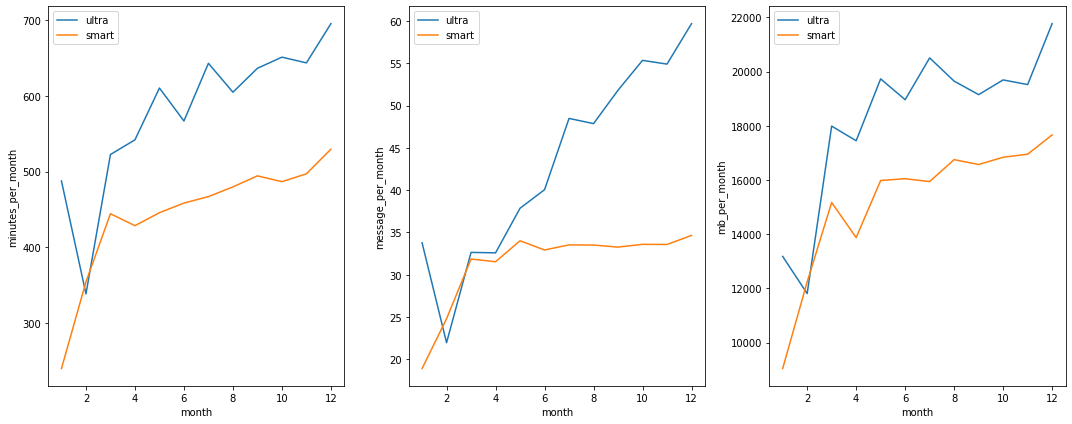

In [63]:
# -------- UPDATE ---------

# посторим графики для каждого тарифа по месяцам для демонстрации расхода минут, сообщений и трафика
fig, axs = plt.subplots(1, 3, figsize=(15,6))

for ax, point in zip(axs, ['minutes_per_month', 'message_per_month', 'mb_per_month']):
    udata = ultra_data.groupby('month')[[point]].mean()
    sdata = smart_data.groupby('month')[[point]].mean()
    
    for df, lb in zip([udata, sdata], ['ultra', 'smart']):
        ax.plot(df, label=lb)
        ax.set_ylabel(point)
        ax.set_xlabel('month')
        ax.legend(loc="upper left")
        
fig.tight_layout()

Из графиков видно:
* для каждого тарифа в течение года расход минут, сообщений и трафика возрастает
* для тарифа _ultra_ расход услуг возрастает стремительнее, сем для _smart_

Посмотрим, сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [64]:
# описательная статистика тарифа ultra
ultra_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].describe()

,minutes_per_month,message_per_month,mb_per_month
count,944.000000,944.000000,944.000000
mean,618.003178,48.322034,19453.939619
std,343.737136,45.813839,10070.955049
min,1.000000,0.000000,0.000000
25%,354.750000,5.000000,11674.750000
50%,603.000000,39.000000,19367.000000
75%,859.250000,78.000000,26861.500000
max,1586.000000,190.000000,48488.000000


In [65]:
# описательная статистика тарифа smart
smart_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].describe()

,minutes_per_month,message_per_month,mb_per_month
count,2164.000000,2164.000000,2164.00000
mean,476.688540,33.064233,16300.75647
std,204.949464,27.252353,5534.04260
min,1.000000,0.000000,1605.00000
25%,327.000000,10.000000,12802.50000
50%,484.000000,28.000000,16552.50000
75%,620.000000,51.000000,20069.00000
max,1059.000000,112.000000,31209.00000


**UPDATE**


Из описания данных следует:
* для _ultra_ абоненты используют:
    * от 1 до 1586 минут, в среднем - 618 мин.
    * от 0 до 190 сообщений, в среднем - 48 сообщений
    * от 0 до 48488 МБ, в среднем - 19454 МБ трафика
    
    
* для _smart_ пользователи расходуют:
    * от 1 до 1059 минуты, в среднем - 477 мин.
    * от 0 до 112 сообщений, в среднем - 33 сообщений
    * от 0 до 31209 МБ, в среднем - 16300 МБ трафика

Посчитаем среднее количество, дисперсию и стандартное отклонение для каждой услуги каждого тарифа.

In [66]:
ultra_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].apply([np.mean, np.var, np.std])

,minutes_per_month,message_per_month,mb_per_month
mean,618.003178,48.322034,1.945394e+04
var,118155.218442,2098.907849,1.014241e+08
std,343.737136,45.813839,1.007096e+04


In [67]:
smart_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].apply([np.mean, np.var, np.std])

,minutes_per_month,message_per_month,mb_per_month
mean,476.688540,33.064233,1.630076e+04
var,42004.282975,742.690740,3.062563e+07
std,204.949464,27.252353,5.534043e+03


 Посмотрим гистограммы для каждой услуги каждого тарифа.

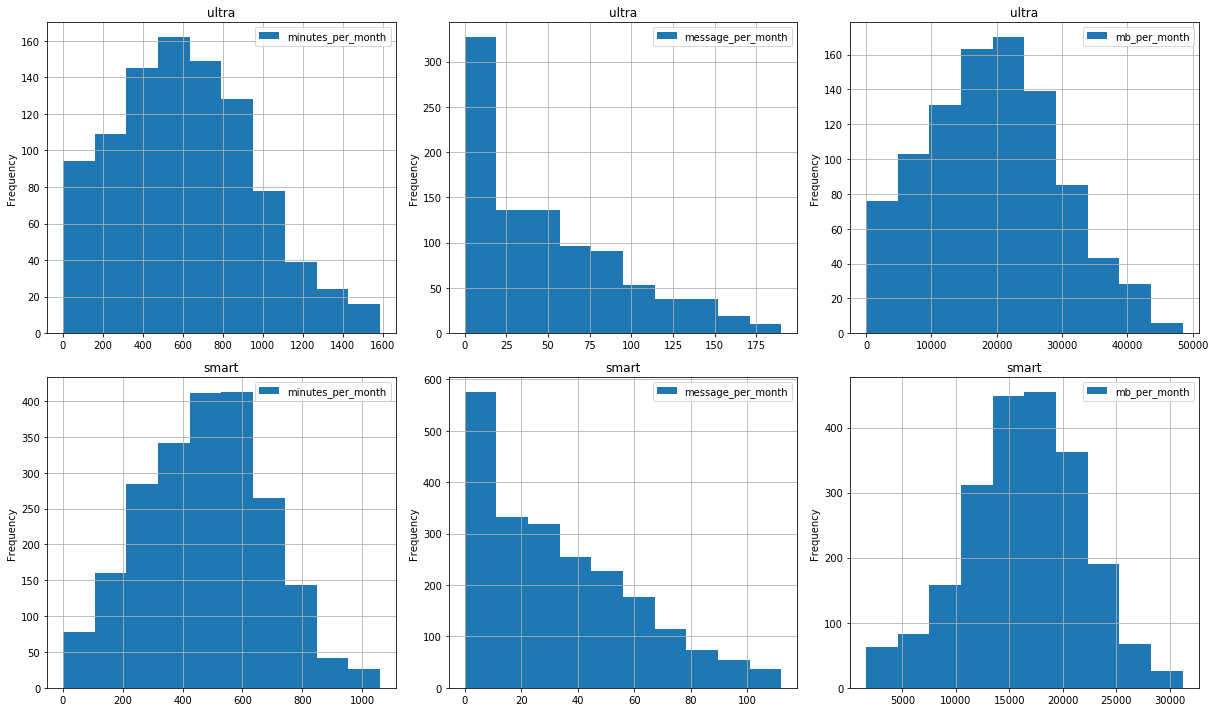

In [68]:
# посмотрим на гистограмму распределения расхода минут, сообщений и трафика в месяц для двух тарифов
fig, axs = plt.subplots(2, 3, figsize=(17,10))
i = 0

for tariff, df in zip(['ultra', 'smart'], [ultra_data, smart_data]):
    for j, point in enumerate(['minutes_per_month', 'message_per_month', 'mb_per_month']):
        data = df[[point]]
        get_figure([data], [tariff], 'hist', tariff, axs[i,j], legend=True)
    i += 1

fig.tight_layout()

### Вывод

Видно, что поведение при использовании каждой услуги поведение пользователей примерно одинаковое:
* использование пакета минут стремится к нормальному распределению, однако медиана у тарифа _ultra_ больше
* использование интренет-трафика также стремится к нормальному распределению аналогично использованию минут
* расход сообщений чаще всего приходится на количество от 0 до 15 сообщений - наименее активно используемая услуга

## 6. Проверка гипотез

### 6.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем _нулевую_ гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна". Тест будет осуществляться как сравнение двух средних, так как сравниваем две выборки по средним.

Сформулируем _альтернативную_ гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается". 

In [69]:
ultra_data[['income']].apply([np.mean, np.var, np.std])

,income
mean,2067.584746
var,136334.139152
std,369.234531


In [70]:
smart_data[['income']].apply([np.mean, np.var, np.std])

,income
mean,1373.035582
var,649039.681119
std,805.629990


Посмотрим на распределение выручки для тарифов "Ультра" и "Смарт".

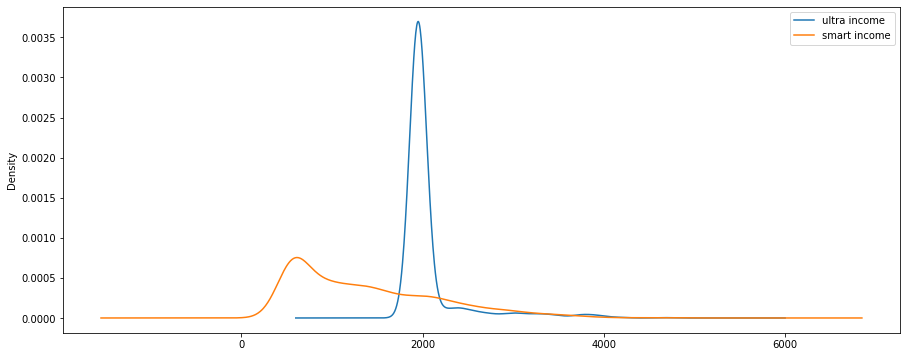

In [71]:
ax = ultra_data.income.plot.kde(figsize=(15,6))
smart_data.income.plot.kde(ax=ax)
ax.legend(['ultra income', 'smart income'])

Для обоих тарифов распределение нормальное, данные количественные и значения друг от друга не зависят, нулевая гипотеза - двухсторонняя, поэтому можем применить t-критерий Стьюдента.

In [72]:
# проверим нулевую гипотезу
check_null_hypothesis(ultra_data.income, smart_data.income)

p-value: 5.006510641928002e-129
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергли,соответственно имеет место альтернативная - "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" ( по значениям средних видно, что у "Ультра" больше).

### 6.2.  Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем _нулевую_ гипотезу: "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов". Тест будет осуществляться как сравнение двух средних, так как сравниваем две выборки по средним.

Сформулируем _альтернативную_ гипотезу: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". 

In [73]:
# из 2 таблиц выбираем данные о доходе и городе, соединяем в одну талицу
ultra_income = ultra_data[['city', 'income']]
smart_income = smart_data[['city', 'income']]
city_income = pd.concat([ultra_income, smart_income])
city_income.sample(5)

,city,income
2425,балашиха,1063
3086,москва,1550
892,санкт-петербург,1950
2335,уфа,1646
2125,пермь,2951


In [74]:
# разделим данные на москву и не москву
moscow_income = city_income[city_income.city == 'москва']
other_income = city_income[city_income.city != 'москва']

In [75]:
# проверка нулевой гипотезы
check_null_hypothesis(moscow_income.income, other_income.income)

p-value: 0.5068419593471337
Не удалось отвергнуть нулевую гипотезу


In [76]:
# посмотрим на  средние
print(moscow_income.income.mean(), other_income.income.mean())

1602.6809917355372 1579.4754294846184


**Вывод**

Согласно посавленной задаче сфомулированы 2 нулевые гипотезы:
1. "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" - гипотеза отвергнута. Соответственно, можно предположить, что верна альтернативная гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" - больше или меньше.


2. "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов" - не получилось отвергнуть гипотезу. Соответственно, средний доход по Москве и другим города примерно одинаковый - 1482 и  1440 (при стандартное отклонение 718).

## 7. Общий вывод

При подготовке данных выполнено:
* преобразование типов данных;
* удаление лишних столбцов;
* поиск пропусков (обнаруженные пропуски нет смсла заменять);
* поиск дубликатов;
* приведение строковых данных к согласованному виду;
* добавление расхода услуг по месяцам для каждого пользователя;
* разделение данных на 2 отдельные талицы для каждого тарифа;
* удалены выбросы.

Из анализа выяснено:
* использование пакета минут, интренет-трафика стремится к нормальному распределению;
* расход сообщений чаще всего приходится на количество от 0 до 15 сообщений - наименее активно используемая услуга.

Согласно поставленной задаче сформулированы и проверены 2 нулевые гипотезы:
1. "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" - гипотеза отвергнута.
2. "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов" - не удалось отвергнуть гипотезу.

Согласно результатам, средняя выручка ultra,больше средней выручки smart. Поэтому предолагаем, что тариф _ultra_ выгоднее с точки зрения прибыли.